In [2]:
import numpy as np
import pandas as pd
import json
import scripts.scrape_gdpr_fines

In [2]:
# scripts.scrape_gdpr_fines.scrape_fines()

In [3]:
with open('data/scraped_fines.json', 'r', encoding='utf-8') as f:
    all_fines = json.load(f)

In [4]:
ungrouped = all_fines['allItems']
fines = pd.json_normalize(ungrouped)

In [4]:
text = pd.read_csv('data/gdpr_article_text.csv')

How are the fines distributed?

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
fines_nozero = fines.assign(price = lambda x: x.price+0.1)

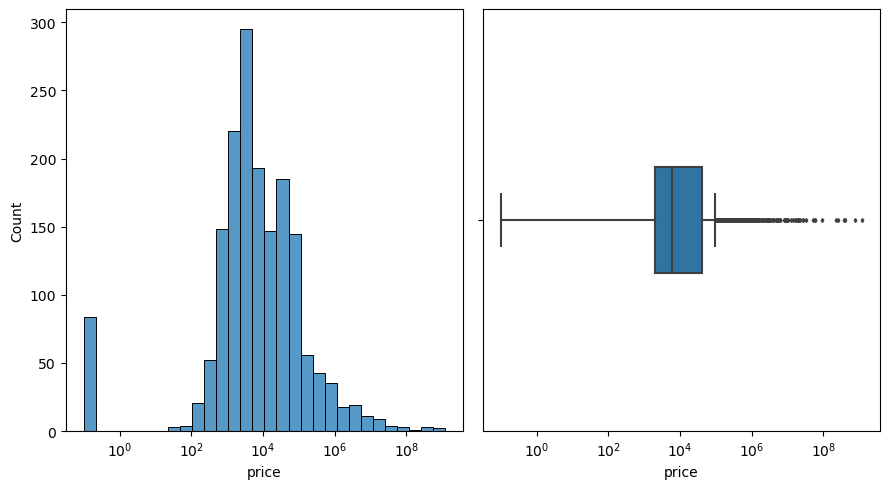

In [7]:
fig, ax = plt.subplots(1,2, figsize=(9, 5))
sns.histplot(data=fines_nozero, x="price", bins=30, log_scale=(True, False), ax=ax[0]);
sns.boxplot(data=fines_nozero, x="price", ax=ax[1], fliersize=2, width=0.25);

fig.axes[1].set_xscale('log')
fig.tight_layout()

In [8]:
fines_long = (
    fines
    .articleViolated.str.extractall(r'([Aa]rt. \d+(?=.*GDPR))')
    .reset_index()
    .rename(columns={'level_0':'id', 0:'article'})
    .assign(
        n_articles_violated = lambda x: (
            x
            .groupby('id')
            .match.transform('max')
            .astype('Int64') + 1
        ),
        article_number = lambda x: (
            x
            .article.str.extract(r'(\d+)')
            .astype('float')
            .astype('Int64')
        )
    )
    .merge(fines, how='right', left_on='id', right_on='id')
    .assign(date = lambda x: pd.to_datetime(x.date, format='%m/%d/%Y'))
    .loc[:, ['id', 'name', 'price', 'authority', 'date', 'controller','article',
             'article_number', 'n_articles_violated', 'type', 'summary']]
    .rename(columns={'price':'total_fine_euro', 'name': 'country'})
)

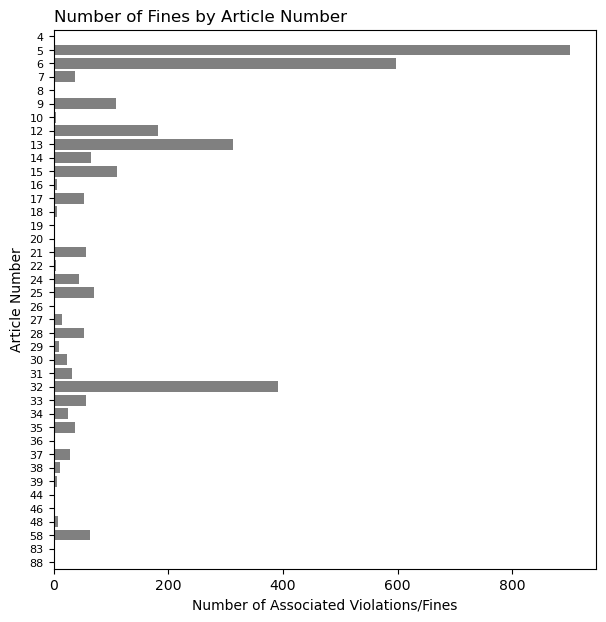

In [9]:
n_citations = (
    fines_long
    .value_counts('article_number')
    .reset_index(name='count')
    .sort_values('article_number')
)


fig, ax = plt.subplots(figsize = (7, 7))

sns.barplot(y='article_number', x='count', data=n_citations, orient='h', color='grey', ax=ax)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.set_ylabel('Article Number')
ax.set_xlabel('Number of Associated Violations/Fines')
ax.set_title('Number of Fines by Article Number', loc='left');


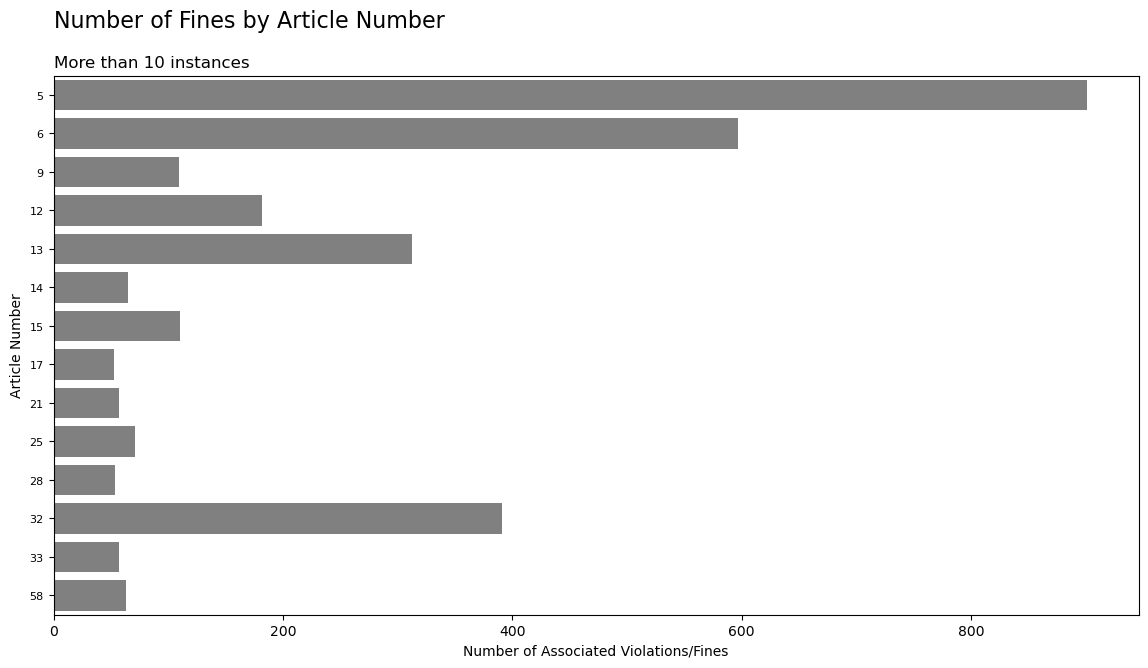

In [10]:
n_citations_min_n = n_citations.query('count > 50')

fig, ax = plt.subplots(figsize = (14, 7))

sns.barplot(y='article_number', x='count', data=n_citations_min_n, orient='h', color='grey', ax=ax)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.set_ylabel('Article Number')
ax.set_xlabel('Number of Associated Violations/Fines')
ax.set_title('More than 10 instances', loc='left')
fig.suptitle('Number of Fines by Article Number', x=ax.get_position().get_points()[0][0], ha='left', fontsize=16, y=0.975);

In [10]:
known_articles = (
    fines_long
    .query('total_fine_euro > 1')
    .sort_values('article_number')
    .dropna(subset='article_number')
)

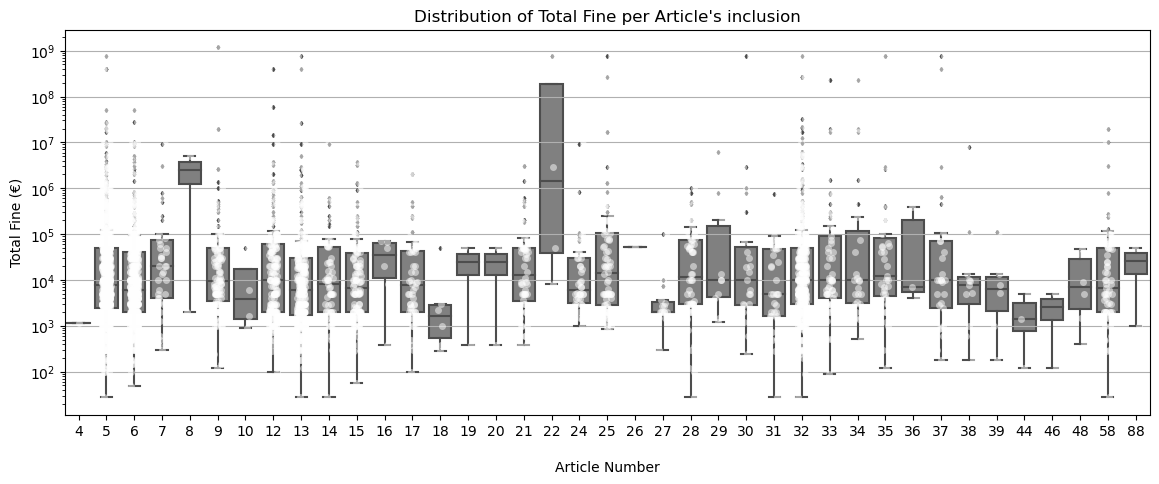

In [11]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_yscale("log")

sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    color='grey',
    fliersize=2
)

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    color='white',
    jitter=0.15,
    alpha=0.5
)

ax.yaxis.grid(True)
ax.set_title(label='', loc='left')
ax.set(xlabel="\nArticle Number", ylabel='Total Fine (€)', title='Distribution of Total Fine per Article\'s inclusion');

In [13]:
top_n_highest_fines = (
    known_articles
    .groupby('article_number')
    .agg({'total_fine_euro': 'sum'})
    .reset_index()
    .sort_values('total_fine_euro', ascending=False)
    .head(10)
)

only_top_n_highest_fines = (
    known_articles
    .loc[known_articles.article_number.isin(top_n_highest_fines.article_number.tolist())]
    .reset_index(drop=True)
)

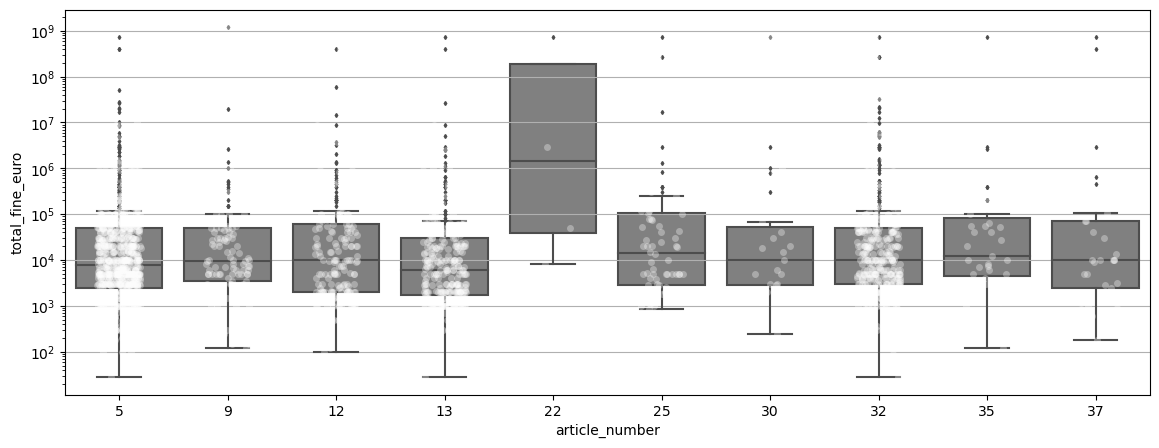

In [17]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_yscale("log")

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=only_top_n_highest_fines,
    color='white',
    jitter=0.2,
    alpha=0.33
)
    
sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=only_top_n_highest_fines,
    color='grey',
    fliersize=2
)

ax.yaxis.grid(True)

In [14]:
# pivot data
gdpr_model_data = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

In [15]:
# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['article_' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

In [20]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,1,2019,Poland,3.972203,1,0,1,1,0,0,0,0,0,0
1,2,2019,Romania,3.397940,1,0,0,0,0,0,0,0,0,0
2,4,2019,Spain,3.903090,0,0,0,0,0,0,0,1,0,0
3,5,2019,Romania,5.176091,0,0,0,0,0,0,0,1,0,0
4,6,2019,Romania,4.301030,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1694,2022,Cyprus,3.176091,1,1,1,0,0,0,0,0,0,0
1196,1697,2023,France,6.716003,0,0,0,0,0,0,0,1,0,0
1197,1698,2020,Malta,3.301030,1,0,0,0,0,0,0,1,0,0
1198,1699,2020,Malta,3.397940,0,0,0,1,0,0,0,0,0,0


<Axes: xlabel='year', ylabel='total_fine_euro'>

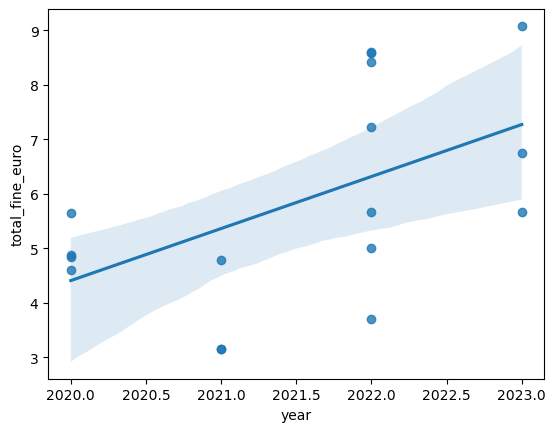

In [21]:
sns.regplot(x='year', y='total_fine_euro', data=gdpr_model_data.query('country == "Ireland"'))

In [16]:
with_controller = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year)
    .loc[:, ['id', 'date', 'year', 'country', 'total_fine_euro', 'article_number', 'violated', 'controller']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id','date', 'year', 'country', 'total_fine_euro', 'article_number', 'controller'])
    .unstack(level=-2, fill_value=0)
)

# sort out indexing
with_controller.columns = with_controller.columns.droplevel(0)
with_controller.columns.name = None

with_controller.columns = ['article_' + str(col) for col in with_controller.columns]

with_controller = with_controller.reset_index()

In [20]:
top5_fines_per_yer = (
    with_controller
    .loc[with_controller.groupby('year')['total_fine_euro'].nlargest(5).reset_index().level_1]
    .copy()
)

In [21]:
highbois = (
    top5_fines_per_yer
    .loc[top5_fines_per_yer.total_fine_euro > 2e8, ['country', 'controller', 'date', 'total_fine_euro']]
    .copy()
)

In [22]:
def strfind(term):
    "shorthand"
    return highbois.controller.str.contains(term)

highbois = highbois.assign(
    shortname = np.select(
        [strfind("Meta"), strfind("Amazon"), strfind("Google"), strfind("Microsoft"), strfind("Vodafone")],
        ["Meta", "Amazon", "Google", "Microsoft", "Vodafone"]
    )
)

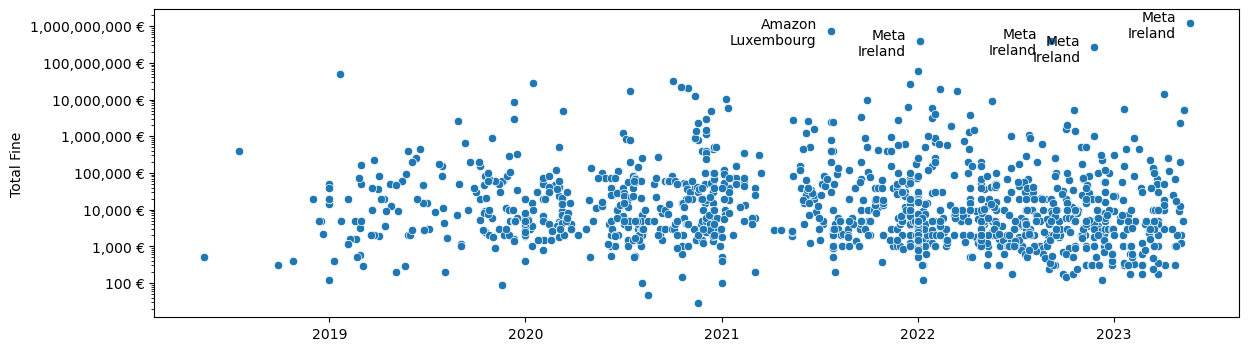

In [23]:
fig, ax = plt.subplots(1, figsize=(14, 4))

sns.scatterplot(x='date', y='total_fine_euro', data=with_controller)
# sns.lineplot(x='date', y='total_fine_euro', data=with_controller)

for _, boi in highbois.iterrows():
    xy = (boi.date, boi.total_fine_euro)
    text = boi.shortname + '\n' + boi.country
    ax.annotate(text=text,
            xy=xy, xycoords='data',
            xytext=(-10, -10), textcoords='offset points',
            ha='right',
            fontsize='medium'
    )

ax.set(title=None, xlabel=None, ylabel ="Total Fine")
ax.set_yscale("log")
ax.yaxis.set_major_formatter('{x:,.0f} €')

<Axes: xlabel='total_fine_euro', ylabel='Count'>

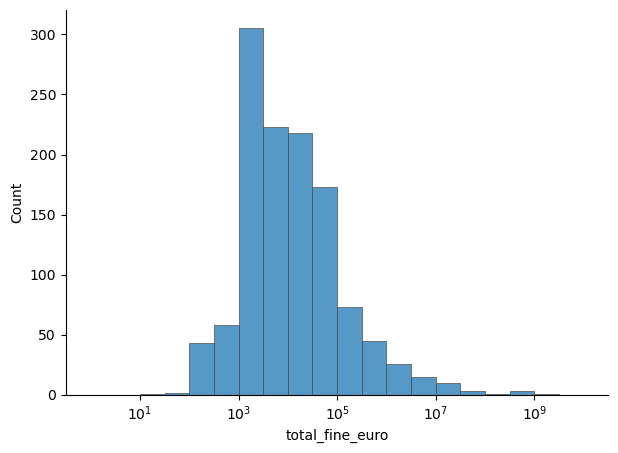

In [32]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    with_controller,
    x="total_fine_euro",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
    binrange=(0, 10),
    binwidth=0.5
)

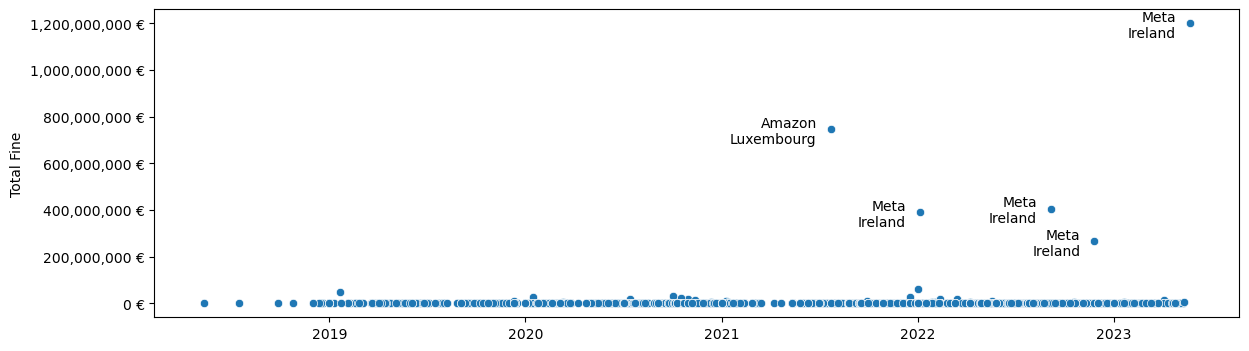

In [24]:
fig, ax = plt.subplots(1, figsize=(14, 4))

sns.scatterplot(x='date', y='total_fine_euro', data=with_controller)
# sns.lineplot(x='date', y='total_fine_euro', data=with_controller)

for _, boi in highbois.iterrows():
    xy = (boi.date, boi.total_fine_euro)
    text = boi.shortname + '\n' + boi.country
    ax.annotate(text=text,
            xy=xy, xycoords='data',
            xytext=(-10, -10), textcoords='offset points',
            ha='right',
            fontsize='medium'
    )

ax.set(title=None, xlabel=None, ylabel ="Total Fine")
ax.yaxis.set_major_formatter('{x:,.0f} €')

In [101]:
with_controller.assign(fine_class = np.where(with_controller.total_fine_euro > 2e9, 'high', 'medium'))

,id,date,year,country,total_fine_euro,controller,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37,fine_class
0,1,2019-10-18,2019,Poland,9380,Polish Mayor,1,0,1,1,0,0,0,0,0,0,medium
1,2,2019-10-17,2019,Romania,2500,UTTIS INDUSTRIES,1,0,0,0,0,0,0,0,0,0,medium
2,4,2019-10-16,2019,Spain,8000,Iberdrola Clientes,0,0,0,0,0,0,0,1,0,0,medium
3,5,2019-10-09,2019,Romania,150000,Raiffeisen Bank SA,0,0,0,0,0,0,0,1,0,0,medium
4,6,2019-10-09,2019,Romania,20000,Vreau Credit SRL,1,0,0,0,0,1,0,0,0,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1694,2022-01-01,2022,Cyprus,1500,Physician,1,1,1,0,0,0,0,0,0,0,medium
1196,1697,2023-05-10,2023,France,5200000,Clearview AI,0,0,0,0,0,0,0,1,0,0,medium
1197,1698,2020-01-01,2020,Malta,2000,Unknown,1,0,0,0,0,0,0,1,0,0,medium
1198,1699,2020-01-01,2020,Malta,2500,Unknown,0,0,0,1,0,0,0,0,0,0,medium


Text(0.5, 0, '')

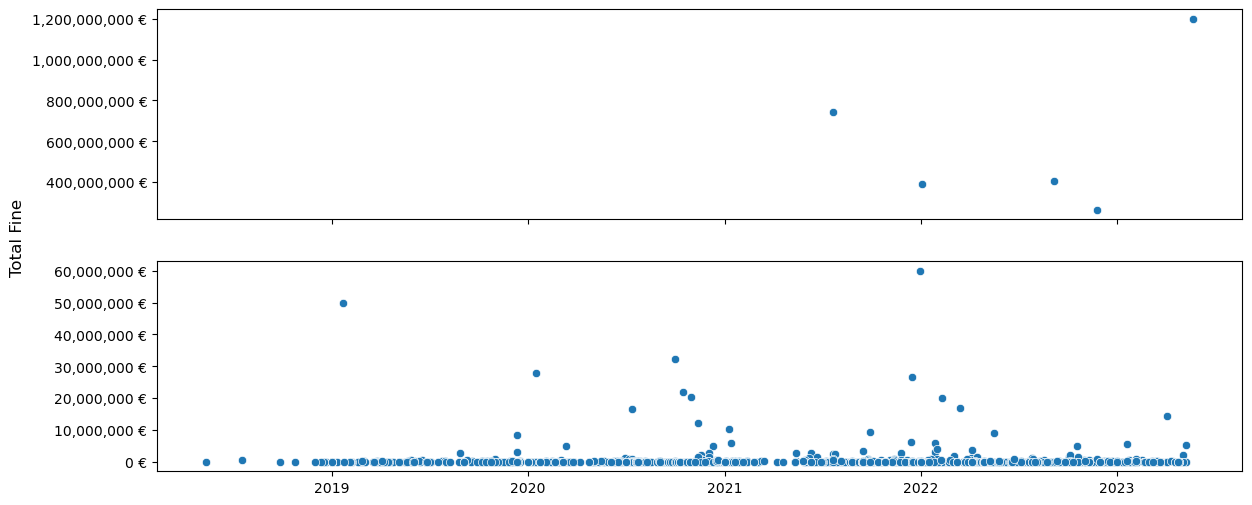

In [124]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, sharey=False)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro > 2e8'),
    ax=ax[0]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro <= 2e8'),
    ax=ax[1]
)

for axis in ax:
    axis.yaxis.set_major_formatter('{x:,.0f} €')
    axis.set_ylabel(None)
fig.supylabel('Total Fine')
plt.xlabel(None)

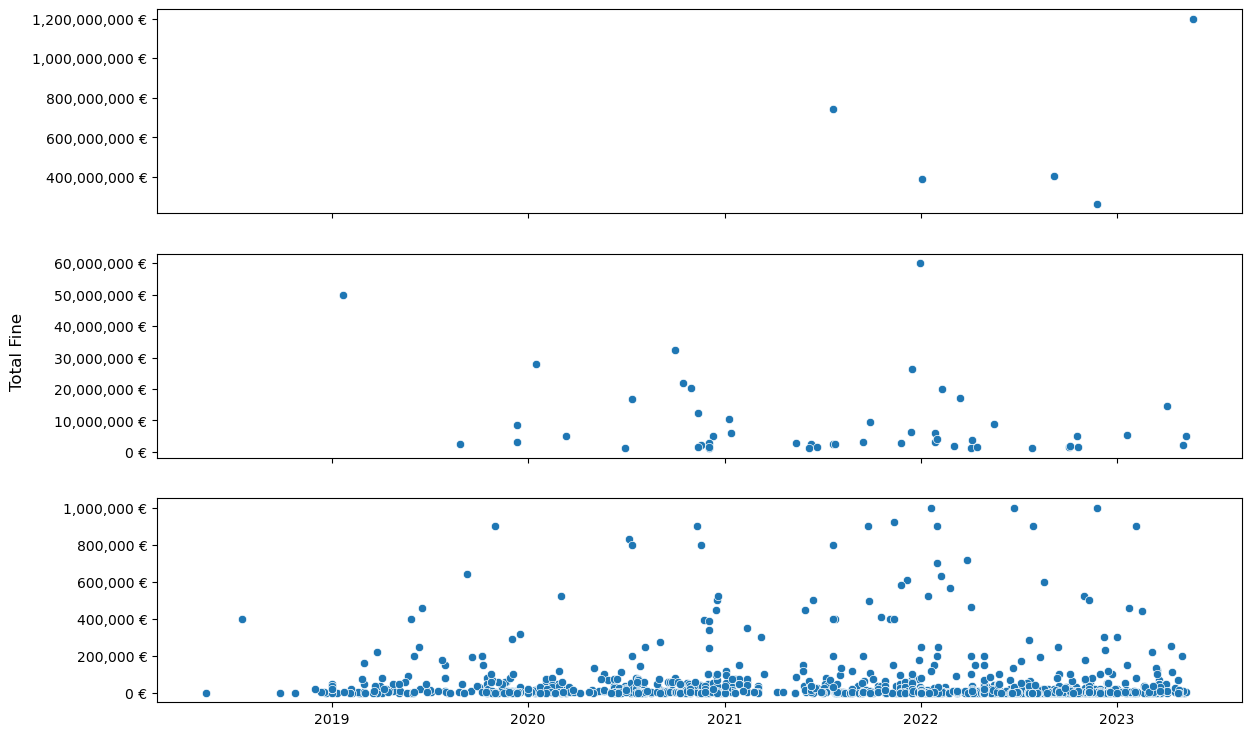

In [126]:
fig, ax = plt.subplots(3, figsize=(14, 9), sharex=True, sharey=False)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro > 2e8'),
    ax=ax[0]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('1e6 < total_fine_euro <= 2e8'),
    ax=ax[1]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro <= 1e6'),
    ax=ax[2]
)

for axis in ax:
    axis.yaxis.set_major_formatter('{x:,.0f} €')
    axis.set_ylabel(None)
    
fig.supylabel('Total Fine')
plt.xlabel(None);

In [265]:
penguins = sns.load_dataset('penguins')

In [272]:
import seaborn.objects as so

In [275]:
import matplotlib as mpl

In [119]:
top_25_fined_controllers = (
    fines_long
    .groupby('controller')
    .agg({'total_fine_euro':['sum', 'count', 'mean']})
    .droplevel(0, axis='columns')
    .reset_index()
    .sort_values('sum', ascending=False)
    .head(25)
)

In [123]:
fines_long

,id,country,total_fine_euro,authority,date,controller,article,article_number,n_articles_violated,type,summary
0,1,Poland,9380,Polish National Personal Data Protection Offic...,2019-10-18,Polish Mayor,Art. 28,28,1,Non-compliance with lawful basis for data proc...,No data processing agreement has been conclude...
1,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 12,12,4,Information obligation non-compliance,A controller was sanctioned because he had unl...
2,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 13,13,4,Information obligation non-compliance,A controller was sanctioned because he had unl...
3,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 5,5,4,Information obligation non-compliance,A controller was sanctioned because he had unl...
4,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 6,6,4,Information obligation non-compliance,A controller was sanctioned because he had unl...
...,...,...,...,...,...,...,...,...,...,...,...
3400,1699,Malta,2500,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 32,32,2,Failure to comply with data processing principles,The data controller had previously disclosed t...
3401,1700,Malta,20000,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 13,13,2,Non-compliance with subjects' rights protectio...,The data controller had previously failed to c...
3402,1700,Malta,20000,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 15,15,2,Non-compliance with subjects' rights protectio...,The data controller had previously failed to c...
3403,1701,Malta,4000,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 13,13,2,Non-compliance with subjects' rights protectio...,The data controller had previously sent unsoli...


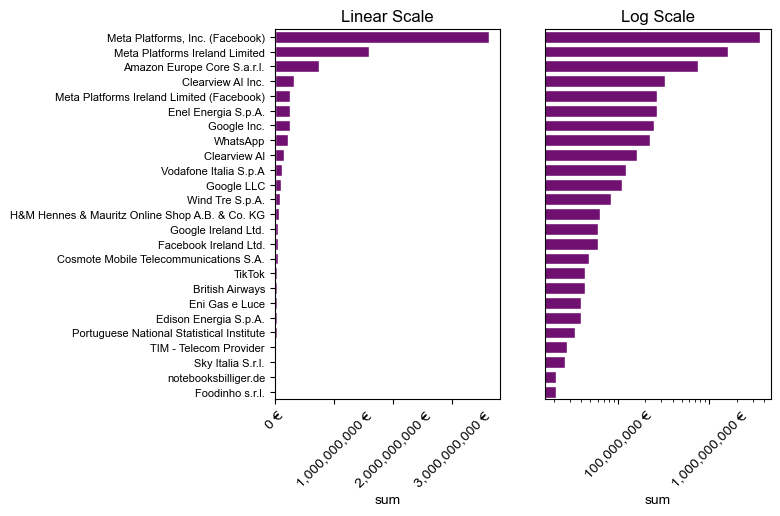

In [28]:
fig, ax = plt.subplots(1, 2)

sns.set_style('whitegrid')
sns.barplot(y='controller', x='sum', orient='h', data=top_25_fined_controllers, ax=ax[0], color='purple')
sns.barplot(y='controller', x='sum', orient='h', data=top_25_fined_controllers, ax=ax[1], color='purple')

fig.axes[0].set(title='Linear Scale', ylabel='')
ax[0].tick_params(axis="y", labelsize=8)
ax[0].xaxis.set_major_formatter('{x:,.0f} €')
ax[0].tick_params(axis='x', rotation=45)
fig.axes[1].set(xscale='log', ylabel='', yticklabels='', yticks=[], title='Log Scale')
ax[1].xaxis.set_major_formatter('{x:,.0f} €')
ax[1].tick_params(axis='x', rotation=45)

In [29]:
top_25_fined_controllers

,controller,sum,count,mean
723,"Meta Platforms, Inc. (Facebook)",3630000000,7,5.185714e+08
721,Meta Platforms Ireland Limited,1594000000,6,2.656667e+08
62,Amazon Europe Core S.a.r.l.,746000000,1,7.460000e+08
265,Clearview AI Inc.,330000000,22,1.500000e+07
722,Meta Platforms Ireland Limited (Facebook),265000000,1,2.650000e+08
419,Enel Energia S.p.A.,265000000,10,2.650000e+07
505,Google Inc.,250000000,5,5.000000e+07
1190,WhatsApp,225000000,1,2.250000e+08
266,Clearview Al,160000000,8,2.000000e+07
1169,Vodafone Italia S.p.A,122516010,10,1.225160e+07
